# Introduction to Regression

This tutorial proves an overview of linear regression. It illustrates fitting a polynomial to noisy data, including the role of the sum of the weighted squared differences (which we can treat as a reponse curve), degrees of freedom, the gradient of that surface (Jacobian) and overfitting.

We use a very simple model (a polynomial function) to illustrate these core concepts and the maths underpinning them. When the models get more complicated, we will need more powerfull tools (i.e. PEST/PEST++). However, many of the underlying concepts will be similar.

In [10]:
import numpy as np
import scipy.optimize as spo
import pandas as pd
import matplotlib.pyplot as plt
import regression_helper as rh
import ipywidgets as widgets

## First cook up some data
In the tutorial folder there is a file named `regression_helper.py` that we have imported as `rh`. It contains functions used throughout this notebook. You do not need to know the details of those functions, merely to follow the ideas discussed herein.

We are going to generate some data using the function `rh.data_cooker()`. This function sets a range of x-values, then makes a "true" set of y-values using a second degree polynomial (e.g. `best_degree=2`). 

The general form of the polynomial is: 

$y=ax^2 + bx + c$

We set $c=0$ for our purposes so that we have two free parameters: $a$ and $b$. Values of $y$ are observations. The function also adds noise to the "true" observations.

In [2]:
xplot, x, y_data, poly_func, polypars = rh.data_cooker()

Let's plot this data. The `rh.plot_truth()` function conveniently does this for us. 

The blue line is the "true" model. Think of this as reality. 

Orange dots are observations of reality. They represent what we can measure. For example, in a groundwater context, these would be things such as water levels and contaminant concentrations. Measurements do not all coincide with the blue line because of "noise". Noise can be caused by errors when taking or processing a measurement. 

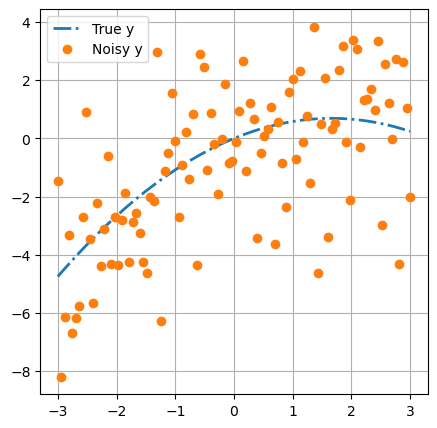

In [4]:
rh.plot_truth(xplot,x,y_data, poly_func)

## Build a Model

We are going to construct a model with which we hope to explain the "measured" data. We will use this model to subsequently make a prediction.

Our model is a 2nd degree polynomial function (i.e. it has three variables). In this scenario we actually know the number of unknown parameters that exist in "reality". Thus, in principle, it is possible to build a perfect model.

We will use the Numpy `poly1d()` class to generate a polynomial function as our model. We specified the coefficient $c$ as being equal to zero. Coefficients $a$ and $b$ are unkown. In the example below, we specify a "first-guess" for $a$ and $b$ as -1 and 0.5, respectively.

We can then use the `rh.plot_truth()` function to display our model with measured data and the truth.

The polynomial we have specified for the model is: 
    2
-1 x + 0.5 x


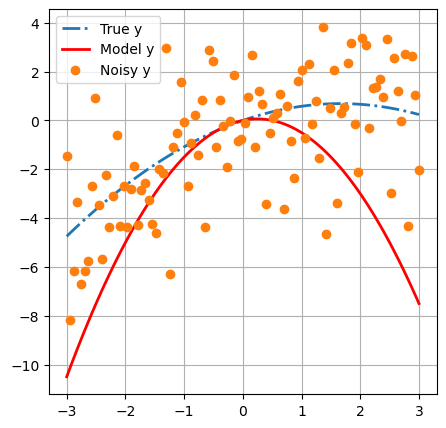

In [5]:
a = -1
b = 0.5
c = 0
model = np.poly1d([a, b, c]) 
print('The polynomial we have specified for the model is: ')
print(model)

rh.plot_truth(xplot,x,y_data, poly_func, model)

## Measure Model-to-Observation Fit 

Calibration of a model to improve history matching is essentially a search for parameters which allow a model to "better" fit a set of observation data. This is accomplished through minimizing a so called "objective function" (often displayed as Phi, $\Phi$). The objective function can be defined in many ways. Perhaps the most common is the “**sum of squared weighted differences (or residuals)**” between model outputs and field observations:

$\Phi=\sum_{i=1}^{n}\left[w_{hi}(y_{i}-m\left(x_{i}\right)\right)]^{2}$

where: 

 * $y_i$ is the $i^{th}$ observation.
 * $m\left(x_i\right)$ is the modeled equivalent to the $i^{th}$ observation.
 * $w_{hi}$ is the weight assigned to the observation.
 * $n$ is the number of pairs of modeled and observed values.
 

**Residuals**, $(y_{i}-m\left(x_{i}\right))$, are the difference between observations and the corresponding model outputs. For example, the difference between heads observed at a well and the simulated value of head at the corresponding location in a model. Or, in our current case, the difference between the orange dots and the black line at the same location along the x-axis.

Residuals for our polynomial model are calculated and displayed below:

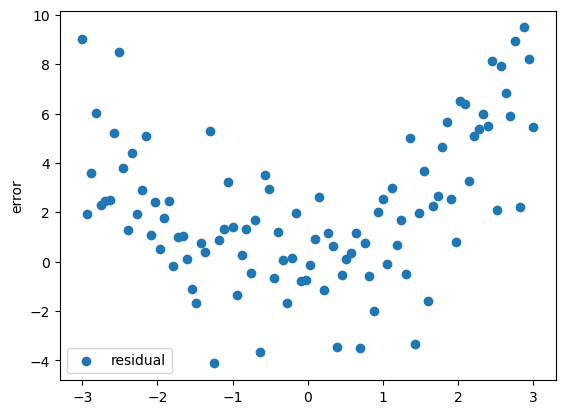

In [7]:
# residuals = observed values - modelled values
def errfun(pars, x, y_data):
    residuals = y_data - np.poly1d([*pars, 0])(x)
    return residuals

# run the function with values of a,b defined earlier
residuals = errfun([a,b], x, y_data)

# plot residuals on the x-axis
plt.scatter(x, residuals, label='residual')
plt.ylabel('error')
plt.legend();


**Weights**, $w_{hi}$, are applied to this residual to increase or decrease the contribution of individual observations to the total objective function. Ideally weights are assigned to give greater relevance to observations that have less noise, or are less uncertain. In practice, weighting strategies usually need to be more nuanced and will often reflect a quantitative measure of a modeller's judgment as to which observations are most relevant to inform parameters that affect the prediction of interest. For the purposes of this tutorial, we will assume uniform weights all equal to 1.0 so they will play no further role herein.

So! Residuals are calculated, multiplied by a weight to adjust their relative contributions, then squared to make all residuals positive. Finally all residuals are summed to determine the value of the **objective function** ($\Phi$). Below we implement the equation described previously as a function. 

In [15]:
def calc_sse(pars, x, y_data):
    model = np.poly1d([pars[0], pars[1], 0]) 
    # the sum of squared residuals (not weighted)
    sse = sum((y_data - model(x))**2)
    return sse

phi_0 = calc_sse([a,b], x, y_data)
print('Phi =',phi_0)

Phi = 1356.375221335682


**History-Matching** is achieved by minimizing the value of this objective function. **Calibration** is achieved by finding the *unique* solution which minimizes the objective function.

## The Response Surface

Now, we can use $\Phi$ to evaluate the **response surface**. In other words, "how $\Phi$ changes with changes in parameter values". 

The function `rh.plot_sse()` calculates and plots $\Phi$ for a range of values of the two parameters ($a$ and $b$). Inspecting the plots below allow us to idenitfy the values of $a$ and $b$ where $\Phi$ is smallest.

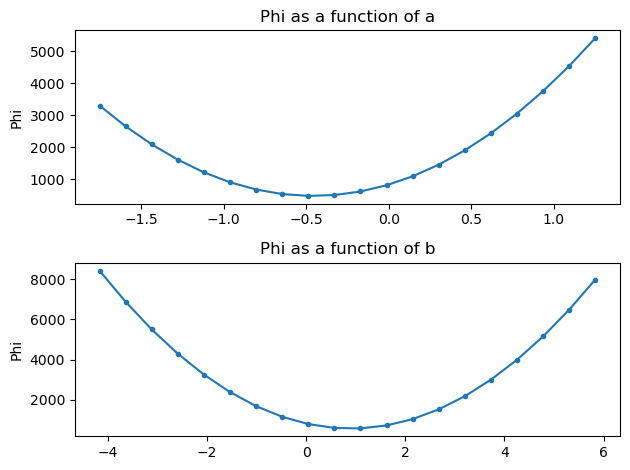

In [16]:
a,b = rh.plot_sse(polypars, x, y_data)

The response surface is easier to visualize as a contour plot. From this plot we can see that $a$ and $b$ are not independent. The value of $b$ that provides the "best fit" depends on what value of $a$ is considered, and vice versa. 

However, there is a "best fit". That is the point on this (two-dimensional) surface at which $\Phi$ is smallest. (Finding that point is the goal of calibration.) This is easy to visualize for a two-dimensional problem. As we move into higher dimensions, things get a bit more challenging. However, the concepts are similar. 

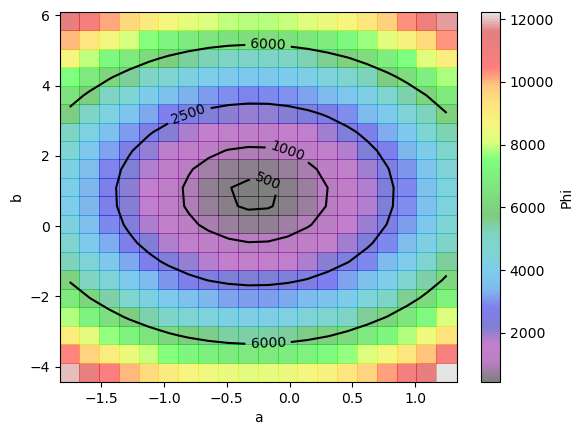

In [17]:
A, B, SSE_AB = rh.contour_sse(a, b, x, y_data)

## Fit a Polynomial Function

Now we will fit our polynomial model to minimize the misfit between measured and modelled values. Recall that we are assuming a polynomial of the same degree as was used to generate the data (e.g. 2 unkown parameters).

We will use the least squares method, as implemented in `scipy.optimize` package, to minimize the `errfun()` function that we wrote earlier. (Recall that `errfun()` calculates the residuals between modelled and "measured" values for our polynomial function.)

Essentially, the optimizer will iteratively adjust the value of each parameter ($a$ and $b$) in turn. By comparing the effect of parameter changes on the change in objective function ($\Phi$), it calculates the slope of the objective function surface. From this it determines the direction in parameter space to take in order to head towards the minimum value of the objective function. It does this until it reaches some user defined criteria to stop (usually when improvements in $\Phi$ become small).

In [27]:
# fit the polynomial using scipy.optimize.least_squares()
sol = spo.least_squares(errfun,[-2,2],args=(x,y_data))
y_fit_pars_best = [*sol.x,0]

# the best fit parameters for our polynomial
y_fit_pars_best

 active_mask: array([0., 0.])
        cost: 211.94615442318832
         fun: array([ 3.73318737, -3.14803106, -1.25826805,  1.41756831, -2.09199969,
       -1.73036473, -1.44532008,  1.46295091,  4.93199872,  0.41839358,
       -1.91261178,  1.38947229, -0.892655  ,  0.24990438,  2.626861  ,
       -1.22999793,  0.2728721 , -1.51212435, -0.07931484,  0.73634868,
       -1.76450382, -0.47455094, -0.27904414, -1.09156295, -2.20086213,
       -2.67726443, -0.15082056, -0.39075207,  4.60147967, -4.7392126 ,
        0.34754424,  0.8549412 ,  2.82547296,  1.10226498, -1.59733929,
        0.08383741,  1.16144501, -0.55716232,  1.60518397, -3.67952218,
        3.51271932,  2.97958908, -0.63304632,  1.25525743,  0.12297678,
       -1.63658304,  0.19195214,  2.01229986, -0.75538834, -0.74912134,
       -0.15111098,  0.86062846,  2.54639173, -1.28353565,  0.99899736,
        0.41101101, -3.74167943, -0.86612906, -0.29500311, -0.11214279,
        0.61653977, -4.11838576,  0.05269104, -1.3970593 , 

As we can see, $\Phi$ is reduced:

In [28]:
# calculate Phi with calibrated model
phi_calib = calc_sse(y_fit_pars_best, x, y_data)

# reduction in Phi
print(f'Initial Phi: {phi_0}')
print(f'Minimum Phi: {phi_calib}')
print(f'Percentage of initial Phi: {round(100*phi_calib/phi_0, 2)} %')

Initial Phi: 1356.375221335682
Minimum Phi: 423.89230884637647
Percentage of initial Phi: 31.25 %


And if we plot modelled values with the best fit parameters:

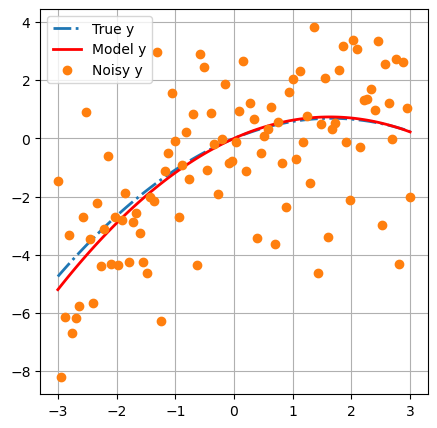

In [29]:
# construct the model with best fit parameteres
calib_model = np.poly1d(y_fit_pars_best) 

# plot 
rh.plot_truth(xplot,x,y_data, poly_func, calib_model)

So how well did we do? Let's compare the "true" values of $a$ and $b$ with the "best fit" values.

In [30]:
print('True parameters are:              a={0:.4f}, b={1:.4f}, c={2}'.format(*polypars))
print('The best-estimate parameters are: a={0:.4f}, b={1:.4f}, c={2}'.format(*y_fit_pars_best))

True parameters are:              a=-0.2503, b=0.8312, c=0.0
The best-estimate parameters are: a=-0.2764, b=0.9036, c=0


## The Jacobian (or Sensitivity) Matrix

The Jacobian matrix, sometimes referred to as a sensitivity matrix, contains the gradients of parameter changes in regard to changes in values of observations. It is a matrix of dimensions ($m * n$), in which $m$ is the number of adjustable parameters and $n$ is the number of observations.

For each parameter-observation combination, we can see how much the observation value changes due to a small change in the parameter. If $y$ are the observations and $x$ are the parameters, the equation for the $i^{th}$ observation with respect to the $j^{th}$ parameter is:  

### $\frac{\partial y_i}{\partial x_j}$

This can be approximated by finite differences as :  

### $\frac{\partial y_i}{\partial x_j} \approx \frac{y\left(x+\Delta x \right)-y\left(x\right)}{\Delta x}$

These provide information on how "sensitive" observations are to parameter changes. They can provide lots of usefull information, such as which parameters are more relevant for improving the fit with measured data or, perhaps more importantly, which parameters affect a simulated prediction.

`scipy.optimize.least_squares` provides a method to access a modified Jacobian matrix at the solution. Instead of changes for individual observations, here we can see how the "cost function" changes with changes in parameter values. Use the `rh.plot_jacobian()` function to display a graph of the cost function versus changes in parameter value.

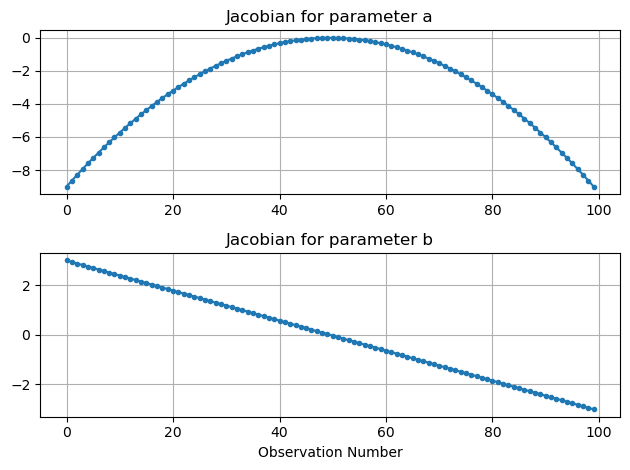

In [26]:
rh.plot_jacobian(sol)

## Make a Prediction

Now let us use our model to make a prediction. Because we also know the "truth" we can compare our model prediction to the true value. The function `rh.plot_prediction()` plots the "truth", the data and the model simulated values. Values of the "sum of squared error" (SSE) for the calibration data and the prediction are also shown.

As you can see, even though the model has the same degrees as the truth (i.e. the same numbers of parameters) and in principle is able to perfectly match "truth", the prediction has error. This error is introduced by trying to fit the model to observations that include "noise". 

(*Try restarting the notebook and running it again. As the random seed changes each time, you should see different values of SSE prediction. Try this a few times. Do you think you can predict how much error to expect?*)

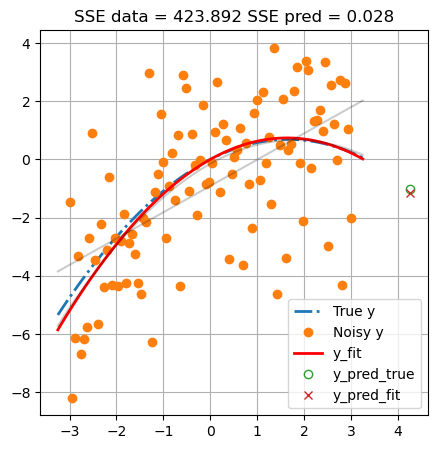

In [31]:
rh.plot_prediction(x, y_data, poly_func, np.poly1d(y_fit_pars_best))    

## Over/Underfitting

So far we have considered a scenario in which our model has the same (perfect) number of parameters as the "truth". Let's see what happens if we use less or more parameters (in our case, degrees of freedom in the polynomial function).

The widget below allows you to interactively change the number of parameters in the model (see the sliding bar in the top left labeled `cdegree`). 

Both plots show the same thing. The only difference is that the scale on the y-axis of the plot on the right-hand side is static, so that you can always see a "close-up" of the measured data. The blue line shows the "truth. The black line shows the model "simulated" values. Orange dots are measured data. The true and simulated values of a prediction are shown with a green circle and red X, respectively. 

Model values are updated whenever you shift the slider. (In the background a new model is "calibrated" and the new values are displayed.) Above the plot two values are shown:

1. the absolute error between the true and simulated prediction;
2. everyone's favourite statistic of "good-fit", the coefficient of determination $R^2$

Play around with the slider. 

As you increase the number of parameters, you should note that $R^2$ improves (increases). But what happens to the prediction error? What do you think, is $R^2$ a good measure of a model's ability to make a good prediction? What if we use less parameters? Does that make for a better prediction?


In [32]:
rh.plot_widget(x,y_data, y_fit_pars_best, poly_func)

interactive(children=(IntSlider(value=2, description='cdegree', max=30, min=1), Output()), _dom_classes=('widg…

So as you can see, increasing parameters to improve the fit does not mean that the prediction is better. But reducing them does not necessarily help either. 

The two plots below illustrate this. Both plots illustrate how model error changes with the number of adjustable parameters. The blue line plots error in regard to historical data. The red line plots error in regard to the prediction. 

**Data error** decreases with increasing number of parameters. However, **prediction error** increases after the ideal number of parameters is surpassed. This is deemed **overfitting**. More parameters mean the model has more flexibility to fit the measured data. But the measured data has noise! Effectively, after a certain point, we are just improving the fit by making our model very good at simulating "noise". When modeling in the real-world, we employ _regularization_ to avoid this. (Demonstrated for groundwater modelling contexts in subsequent tutorials.)

**Prediction error** is minimized when we have the "correct" number of parameters (in this case, two). Using less parameters results in a worse fit with measured data, as well as greater prediction error. This is deemed **underfitting**. In this case the model does not have sufficient freedom to replicate true behaviour. In practice __this is the case for all groundwater models__. No model has as many parameters (i.e. level of detail) as the real world. (That's why we are modelling in the first place...). 

Using too-few parameters in a model "hard wires" in the model's inability to represent system behaviour. Using too many does not. In practice, when simulating groundwater systems, our models will never have more parameters than exist in reality. Thus, we will always be below the "true" optimal number of parameters. Overfitting in this case becomes a matter of having more adjustable parameters than measured data. During subsequent tutorials we will explore how to handle this in practice.

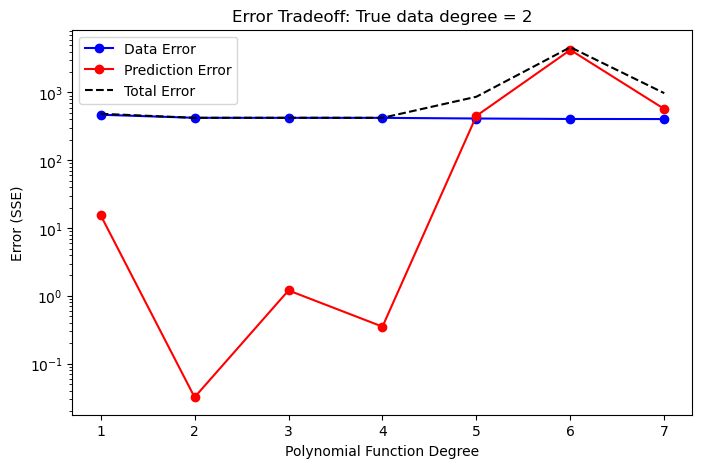

In [33]:
rh.plot_error_tradeoff(x, y_data, poly_func)

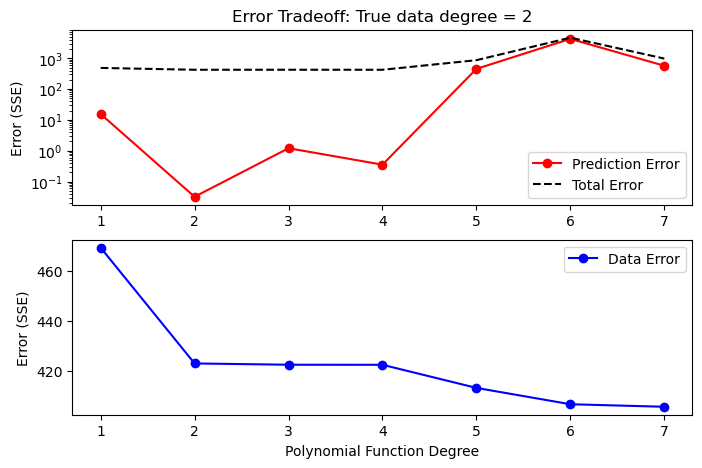

In [34]:
rh.plot_error_tradeoff_fine(x, y_data, poly_func)

## Linking to Groundwater Modelling

At first glance, from what we have shown above, it may appear that _over_-parameterisation leads to larger errors than _under_-parameterisation. This is because this 2-parameter example is very simple. When modelling in the real world the number of parameters of the truth is near-infinite. In the real world __it is impossible to have more parameters than the truth__. 

In groundwater (or environmental) modelling, when we talk about overfitting, in practice we are talking about "fitting to observation noise". Fortunately, we have at our disposal techniques (i.e. regularization) to cope with this, as is discussed in subsequent tutorials. The purpose of this exercise is to demonstrate how off-the-rails things can go without expert input. 

So, in practice __using more parameters is better__, as it reduces the potential for introducing structural error. But, __more parameters requires more care__. As shown above, simply throwing more parameters at a problem can lead to very wrong outcomes. __#badtimes__

## Final Remarks

This notebook has been a very brief introduction to regression. This is intended as a primer, introducing a few fundamental concepts and terminology that play a role in environmental decision-support modelling. Subsequent tutorials will delve into further details as these apply to modelling of groundwater systems.

Perhaps one of the main take aways should be **just because a model has a good fit with measurement data, does not make it a good predictor!**